In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet  # Prophet이 설치되어 있어야 함
import time

c:\Users\jhpark\anaconda3\envs\arima\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


데이터 불러오기

In [4]:
# df = pd.read_csv('real_data.csv')
# # 예시 DataFrame (시간을 인덱스로 설정)
# df['_time'] = pd.to_datetime(df['_time'], utc=True)
# df['_time'] = df['_time'].dt.tz_convert('Asia/Seoul')
# df.set_index('_time', inplace=True)

# # 고유한 tagName별로 데이터를 분리하여 각 tagName에 맞게 변수 이름을 지정
# for tag in df['tagName'].unique():
#     globals()[f"df_{tag}"] = df[df['tagName'] == tag][['_value']]
# df_10 = df_10['2024-09-29 00:00:10+09:00':'2024-09-30 00:00:00+09:00']
# df_10.to_csv('real_data(10).csv')
# df_10resample = df_10.resample('60S').max()[:-1]
# df_10resample.to_csv('real_data(10_resample).csv')

In [5]:
df_10 = pd.read_csv('real_data(10).csv')
df_10resample = pd.read_csv('real_data(10_resample).csv')
print(df_10.shape, df_10resample.shape)

(17279, 2) (1440, 2)


In [6]:
df_10 = df_10.rename(columns={"_time": "ds", "_value": "y"})
df_10["ds"] = pd.to_datetime(df_10["ds"]).dt.tz_localize(None)

df_10resample = df_10resample.rename(columns={"_time": "ds", "_value": "y"})
df_10resample["ds"] = pd.to_datetime(df_10resample["ds"]).dt.tz_localize(None)

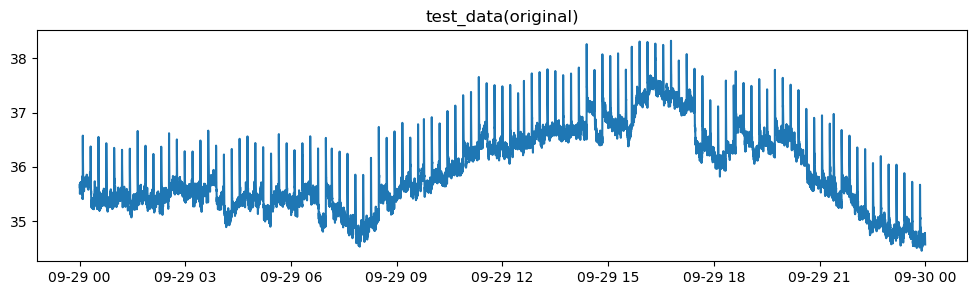

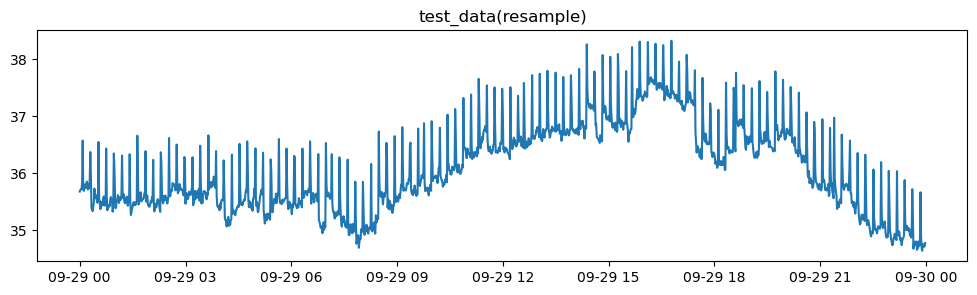

In [7]:
plt.figure(figsize=(12, 3))
plt.plot(df_10['ds'], df_10["y"])
plt.title("test_data(original)")
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(df_10resample['ds'], df_10resample["y"])
plt.title("test_data(resample)")
plt.show()

In [41]:
#########바꿀 변수
predict_period=30
start_train_preiod = 720


# 학습 데이터 (처음 700개만 사용)
train = df_10resample.iloc[:start_train_preiod]
test = df_10resample.iloc[start_train_preiod:start_train_preiod+predict_period]  # 실제값 30개(trend확인용)

14:48:13 - cmdstanpy - INFO - Chain [1] start processing
14:48:14 - cmdstanpy - INFO - Chain [1] done processing


0.5660715103149414


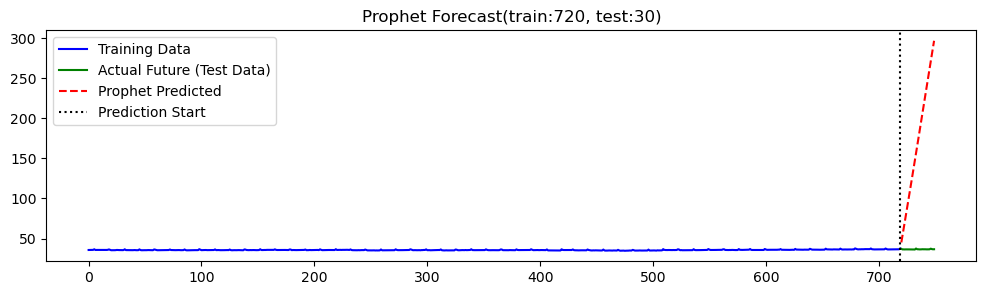

In [42]:
prophet_start = time.time()
# Prophet 모델 학습
prophet_model = Prophet(yearly_seasonality=True)
prophet_model.fit(train)

# Prophet 예측(30일 예측)
future = prophet_model.make_future_dataframe(periods=predict_period)
forecast_prophet = prophet_model.predict(future)[start_train_preiod:start_train_preiod+predict_period]  #예측된 부분만 확인하기
prophet_end = time.time()
print(prophet_end-prophet_start)
# 시각화 (Prophet)
plt.figure(figsize=(12, 3))
# 실제값
plt.plot(train.index, train["y"], label="Training Data", color="blue")
plt.plot(test.index, test["y"], label="Actual Future (Test Data)", color="green")
# Prophet 예측값
plt.plot(forecast_prophet.index+train.index[0], forecast_prophet["yhat"], label="Prophet Predicted", color="red", linestyle="dashed")

plt.axvline(train.index[-1], color="black", linestyle="dotted", label="Prediction Start")
plt.legend(loc="upper left")
plt.title("Prophet Forecast(train:720, test:30)")
plt.show()

c:\Users\jhpark\anaconda3\envs\arima\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\jhpark\anaconda3\envs\arima\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\jhpark\anaconda3\envs\arima\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4.23762321472168


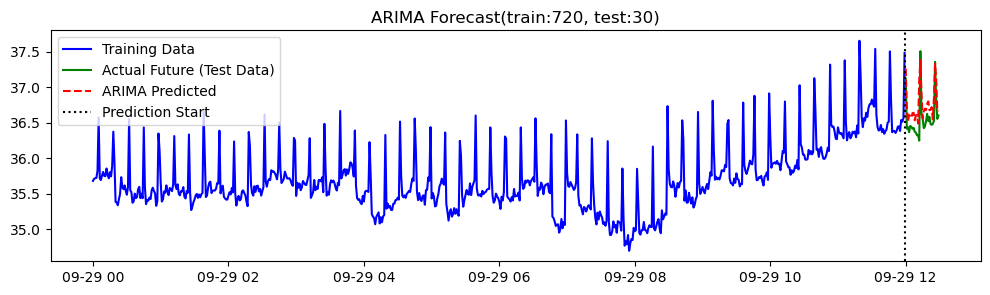

In [43]:
arima_start = time.time()
# ARIMA 모델 학습 (p=5, d=1, q=0 설정, 30일 예측)
arima_model = ARIMA(train["y"], order=(12, 2, 6))  # 기본적인 (p,d,q) 설정
arima_result = arima_model.fit()
forecast_arima = arima_result.forecast(steps=predict_period)
forecast_arima_df = pd.DataFrame({"ds": test["ds"].values, "yhat": forecast_arima.values})
arima_end = time.time()
print(arima_end-arima_start)

# 시각화 (ARIMA)
plt.figure(figsize=(12, 3))
# 실제값
plt.plot(train["ds"], train["y"], label="Training Data", color="blue")
plt.plot(test["ds"], test["y"], label="Actual Future (Test Data)", color="green")
# ARIMA 예측값
plt.plot(forecast_arima_df["ds"], forecast_arima_df["yhat"], label="ARIMA Predicted", color="red", linestyle="dashed")
plt.axvline(train["ds"].iloc[-1], color="black", linestyle="dotted", label="Prediction Start")
plt.legend(loc="upper left")
plt.title("ARIMA Forecast(train:720, test:30)")
plt.show()

resampling전 1시간으로 30분 예측(720 -> 360)

In [51]:
#########바꿀 변수
predict_period=360
start_train_preiod = 720


# 학습 데이터 (처음 700개만 사용)
train = df_10.iloc[:start_train_preiod]
test = df_10.iloc[start_train_preiod:start_train_preiod+predict_period]  # 실제값 30개(trend확인용)

15:24:16 - cmdstanpy - INFO - Chain [1] start processing
15:24:16 - cmdstanpy - INFO - Chain [1] done processing


0.6737232208251953


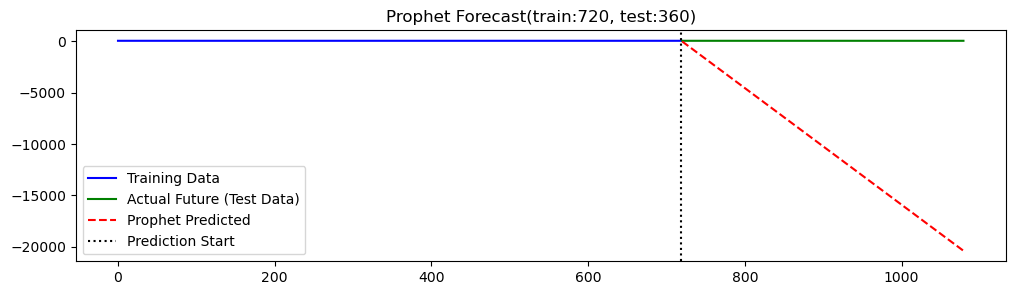

In [52]:
prophet_start = time.time()
# Prophet 모델 학습
prophet_model = Prophet(daily_seasonality=True,weekly_seasonality=True)
prophet_model.fit(train)

# Prophet 예측(30일 예측)
future = prophet_model.make_future_dataframe(periods=predict_period)
forecast_prophet = prophet_model.predict(future)[start_train_preiod:start_train_preiod+predict_period]  #예측된 부분만 확인하기
prophet_end = time.time()
print(prophet_end-prophet_start)
# 시각화 (Prophet)
plt.figure(figsize=(12, 3))
# 실제값
plt.plot(train.index, train["y"], label="Training Data", color="blue")
plt.plot(test.index, test["y"], label="Actual Future (Test Data)", color="green")
# Prophet 예측값
plt.plot(forecast_prophet.index+train.index[0], forecast_prophet["yhat"], label="Prophet Predicted", color="red", linestyle="dashed")

plt.axvline(train.index[-1], color="black", linestyle="dotted", label="Prediction Start")
plt.legend()
plt.title("Prophet Forecast(train:720, test:360)")
plt.show()

c:\Users\jhpark\anaconda3\envs\arima\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\jhpark\anaconda3\envs\arima\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\jhpark\anaconda3\envs\arima\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5.021483421325684


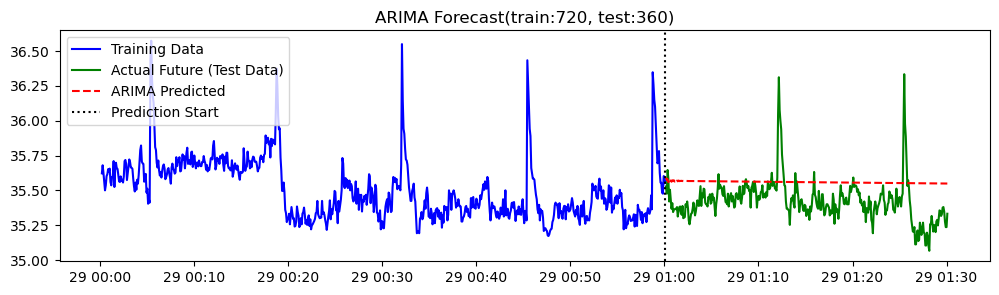

In [54]:
arima_start = time.time()
# ARIMA 모델 학습 (p=5, d=1, q=0 설정, 30일 예측)
arima_model = ARIMA(train["y"], order=(12, 2, 6))  # 기본적인 (p,d,q) 설정
arima_result = arima_model.fit()
forecast_arima = arima_result.forecast(steps=predict_period)
forecast_arima_df = pd.DataFrame({"ds": test["ds"].values, "yhat": forecast_arima.values})
arima_end = time.time()
print(arima_end-arima_start)

# 시각화 (ARIMA)
plt.figure(figsize=(12, 3))
# 실제값
plt.plot(train["ds"], train["y"], label="Training Data", color="blue")
plt.plot(test["ds"], test["y"], label="Actual Future (Test Data)", color="green")
# ARIMA 예측값
plt.plot(forecast_arima_df["ds"], forecast_arima_df["yhat"], label="ARIMA Predicted", color="red", linestyle="dashed")
plt.axvline(train["ds"].iloc[-1], color="black", linestyle="dotted", label="Prediction Start")
plt.legend(loc="upper left")
plt.title("ARIMA Forecast(train:720, test:360)")
plt.show()

10시간으로 예측

In [72]:
#########바꿀 변수
predict_period=360
start_train_preiod = 720


# 학습 데이터 (처음 700개만 사용)
train = df.iloc[:start_train_preiod]
test = df.iloc[start_train_preiod:start_train_preiod+predict_period]  # 실제값 30개(trend확인용)

08:44:41 - cmdstanpy - INFO - Chain [1] start processing
08:44:41 - cmdstanpy - INFO - Chain [1] done processing


0.938948392868042


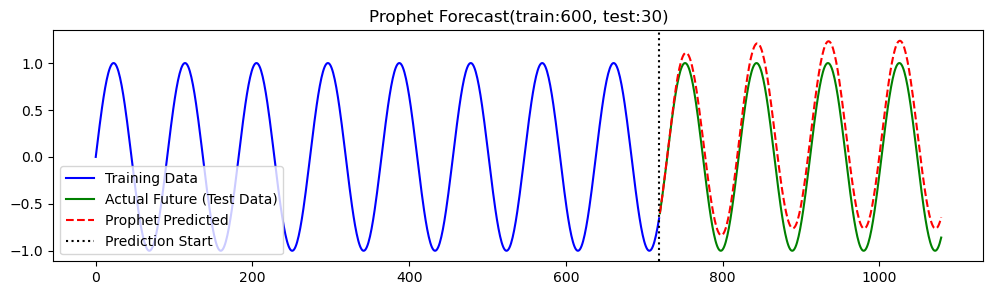

In [76]:
prophet_start = time.time()
# Prophet 모델 학습
prophet_model = Prophet(yearly_seasonality=True,daily_seasonality=True)
prophet_model.fit(train)

# Prophet 예측(30일 예측)
future = prophet_model.make_future_dataframe(periods=predict_period)
forecast_prophet = prophet_model.predict(future)[start_train_preiod:start_train_preiod+predict_period]  #예측된 부분만 확인하기
prophet_end = time.time()
print(prophet_end-prophet_start)
# 시각화 (Prophet)
plt.figure(figsize=(12, 3))
# 실제값
plt.plot(train.index, train["y"], label="Training Data", color="blue")
plt.plot(test.index, test["y"], label="Actual Future (Test Data)", color="green")
# Prophet 예측값
plt.plot(forecast_prophet.index+train.index[0], forecast_prophet["yhat"], label="Prophet Predicted", color="red", linestyle="dashed")

plt.axvline(train.index[-1], color="black", linestyle="dotted", label="Prediction Start")
plt.legend(loc="lower left")
plt.title("Prophet Forecast(train:600, test:30)")
plt.show()

c:\Users\jhpark\anaconda3\envs\arima\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1.8662853240966797


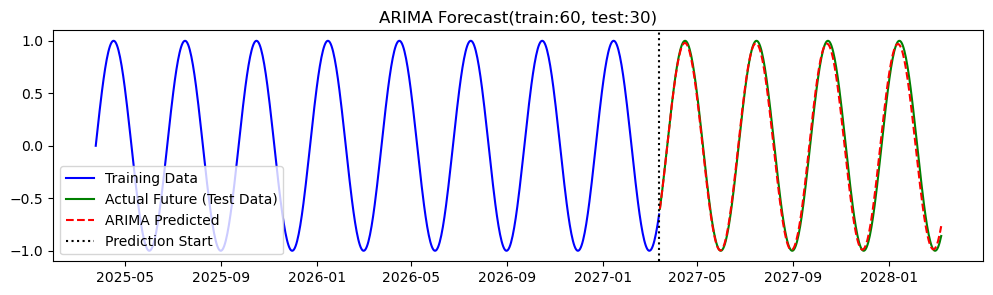

In [71]:
arima_start = time.time()
# ARIMA 모델 학습 (p=5, d=1, q=0 설정, 30일 예측)
arima_model = ARIMA(train["y"], order=(10, 1, 0))  # 기본적인 (p,d,q) 설정
arima_result = arima_model.fit()
forecast_arima = arima_result.forecast(steps=predict_period)
forecast_arima_df = pd.DataFrame({"ds": test["ds"].values, "yhat": forecast_arima.values})
arima_end = time.time()
print(arima_end-arima_start)

# 시각화 (ARIMA)
plt.figure(figsize=(12, 3))
# 실제값
plt.plot(train["ds"], train["y"], label="Training Data", color="blue")
plt.plot(test["ds"], test["y"], label="Actual Future (Test Data)", color="green")
# ARIMA 예측값
plt.plot(forecast_arima_df["ds"], forecast_arima_df["yhat"], label="ARIMA Predicted", color="red", linestyle="dashed")
plt.axvline(train["ds"].iloc[-1], color="black", linestyle="dotted", label="Prediction Start")
plt.legend(loc="lower left")
plt.title("ARIMA Forecast(train:60, test:30)")
plt.show()

기울기 추가후 예측

In [58]:
# 데이터 생성
time_zone = np.linspace(0, 1, 365*3)
trend = 1.5 * time_zone  # 점진적인 증가를 위한 선형 트렌드
result = np.sin(2 * np.pi * 12 * time_zone) + trend  # 기존 사인 파형 + 선형 증가

ds = pd.date_range("2025-03-25", periods=365*3, freq="D")
upper_df = pd.DataFrame({"ds": ds, "y": result})

08:33:55 - cmdstanpy - INFO - Chain [1] start processing
08:33:56 - cmdstanpy - INFO - Chain [1] done processing


0.9260079860687256


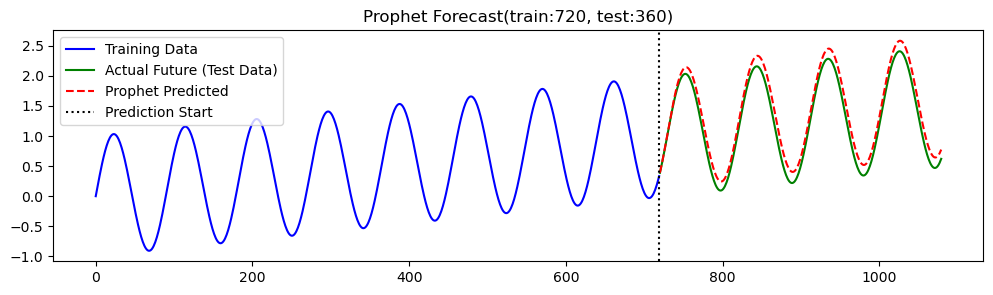

c:\Users\jhpark\anaconda3\envs\arima\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


3.572946310043335


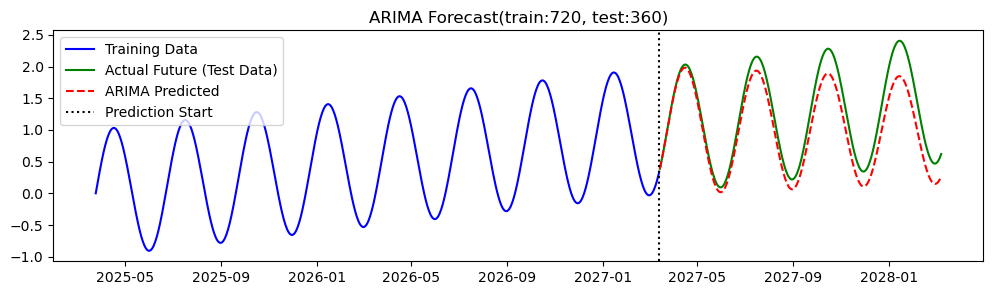

In [66]:
#########바꿀 변수
predict_period=360
start_train_preiod = 720


# 학습 데이터 (처음 700개만 사용)
train = upper_df.iloc[:start_train_preiod]
test = upper_df.iloc[start_train_preiod:start_train_preiod+predict_period]  # 실제값 30개(trend확인용)

prophet_start = time.time()
# Prophet 모델 학습
prophet_model = Prophet(yearly_seasonality=True,daily_seasonality=True)
prophet_model.fit(train)

# Prophet 예측(30일 예측)
future = prophet_model.make_future_dataframe(periods=predict_period)
forecast_prophet = prophet_model.predict(future)[start_train_preiod:start_train_preiod+predict_period]  #예측된 부분만 확인하기
prophet_end = time.time()
print(prophet_end-prophet_start)
# 시각화 (Prophet)
plt.figure(figsize=(12, 3))
# 실제값
plt.plot(train.index, train["y"], label="Training Data", color="blue")
plt.plot(test.index, test["y"], label="Actual Future (Test Data)", color="green")
# Prophet 예측값
plt.plot(forecast_prophet.index+train.index[0], forecast_prophet["yhat"], label="Prophet Predicted", color="red", linestyle="dashed")

plt.axvline(train.index[-1], color="black", linestyle="dotted", label="Prediction Start")
plt.legend()
plt.title("Prophet Forecast(train:720, test:360)")
plt.show()

arima_start = time.time()
# ARIMA 모델 학습 (p=5, d=1, q=0 설정, 30일 예측)
arima_model = ARIMA(train["y"], order=(10, 1, 0))  # 기본적인 (p,d,q) 설정
arima_result = arima_model.fit()
forecast_arima = arima_result.forecast(steps=predict_period)
forecast_arima_df = pd.DataFrame({"ds": test["ds"].values, "yhat": forecast_arima.values})
arima_end = time.time()
print(arima_end-arima_start)

# 시각화 (ARIMA)
plt.figure(figsize=(12, 3))
# 실제값
plt.plot(train["ds"], train["y"], label="Training Data", color="blue")
plt.plot(test["ds"], test["y"], label="Actual Future (Test Data)", color="green")
# ARIMA 예측값
plt.plot(forecast_arima_df["ds"], forecast_arima_df["yhat"], label="ARIMA Predicted", color="red", linestyle="dashed")
plt.axvline(train["ds"].iloc[-1], color="black", linestyle="dotted", label="Prediction Start")
plt.legend()
plt.title("ARIMA Forecast(train:720, test:360)")
plt.show()

노이즈 추가후 예측

C:\Users\jhpark\AppData\Local\Temp\ipykernel_4132\73057310.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


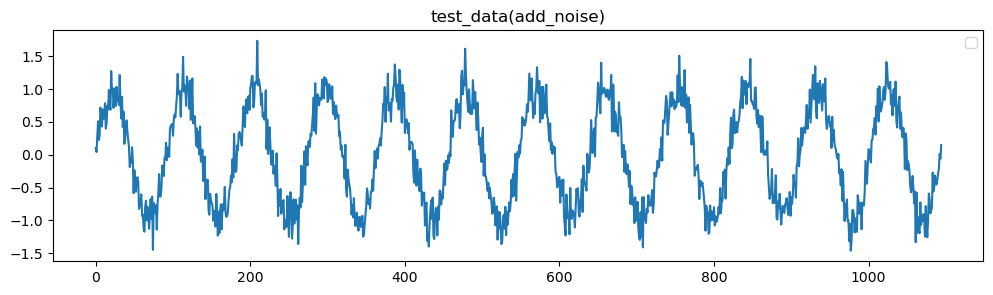

In [81]:
# 전체 구간에 랜덤 노이즈 추가
noise_df = df.copy()
np.random.seed(42)  # 재현성을 위해 시드 고정
noise = np.random.normal(loc=0, scale=0.2, size=len(noise_df))  # 평균 0, 표준편차 0.2인 정규분포 노이즈
noise_df["y"] += noise  # 노이즈 추가
plt.figure(figsize=(12, 3))
# 실제값
plt.plot(noise_df.index, noise_df["y"])
plt.legend()
plt.title("test_data(add_noise)")
plt.show()

08:53:42 - cmdstanpy - INFO - Chain [1] start processing
08:53:42 - cmdstanpy - INFO - Chain [1] done processing


0.5215706825256348


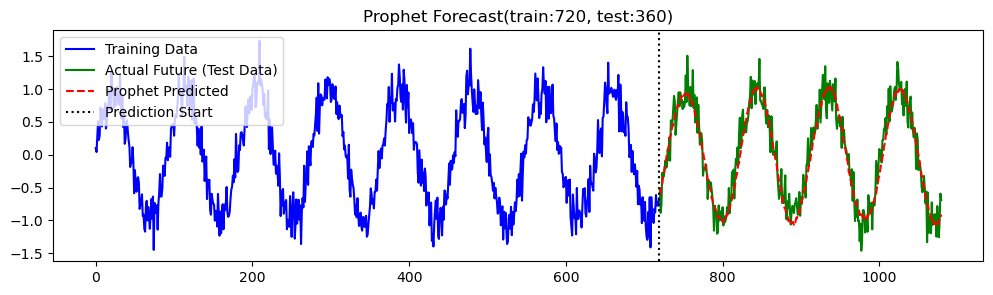

0.597529411315918


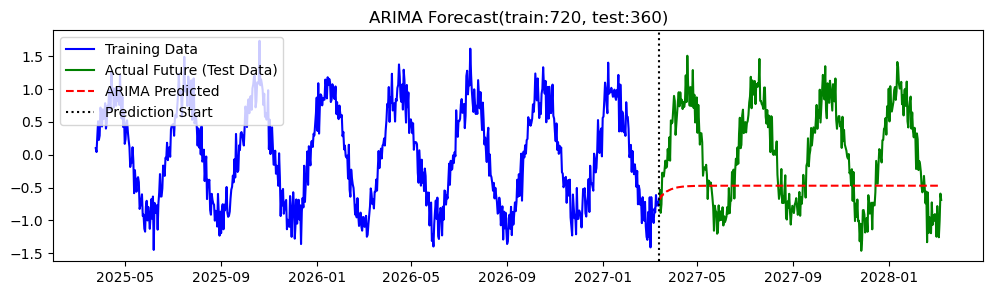

In [82]:
#########바꿀 변수
predict_period=360
start_train_preiod = 720


# 학습 데이터 (처음 700개만 사용)
train = noise_df.iloc[:start_train_preiod]
test = noise_df.iloc[start_train_preiod:start_train_preiod+predict_period]  # 실제값 30개(trend확인용)

prophet_start = time.time()
# Prophet 모델 학습
prophet_model = Prophet(yearly_seasonality=True,daily_seasonality=True)
prophet_model.fit(train)

# Prophet 예측(30일 예측)
future = prophet_model.make_future_dataframe(periods=predict_period)
forecast_prophet = prophet_model.predict(future)[start_train_preiod:start_train_preiod+predict_period]  #예측된 부분만 확인하기
prophet_end = time.time()
print(prophet_end-prophet_start)
# 시각화 (Prophet)
plt.figure(figsize=(12, 3))
# 실제값
plt.plot(train.index, train["y"], label="Training Data", color="blue")
plt.plot(test.index, test["y"], label="Actual Future (Test Data)", color="green")
# Prophet 예측값
plt.plot(forecast_prophet.index+train.index[0], forecast_prophet["yhat"], label="Prophet Predicted", color="red", linestyle="dashed")

plt.axvline(train.index[-1], color="black", linestyle="dotted", label="Prediction Start")
plt.legend(loc="upper left")
plt.title("Prophet Forecast(train:720, test:360)")
plt.show()

arima_start = time.time()
# ARIMA 모델 학습 (p=5, d=1, q=0 설정, 30일 예측)
arima_model = ARIMA(train["y"], order=(10, 1, 0))  # 기본적인 (p,d,q) 설정
arima_result = arima_model.fit()
forecast_arima = arima_result.forecast(steps=predict_period)
forecast_arima_df = pd.DataFrame({"ds": test["ds"].values, "yhat": forecast_arima.values})
arima_end = time.time()
print(arima_end-arima_start)

# 시각화 (ARIMA)
plt.figure(figsize=(12, 3))
# 실제값
plt.plot(train["ds"], train["y"], label="Training Data", color="blue")
plt.plot(test["ds"], test["y"], label="Actual Future (Test Data)", color="green")
# ARIMA 예측값
plt.plot(forecast_arima_df["ds"], forecast_arima_df["yhat"], label="ARIMA Predicted", color="red", linestyle="dashed")
plt.axvline(train["ds"].iloc[-1], color="black", linestyle="dotted", label="Prediction Start")
plt.legend(loc="upper left")
plt.title("ARIMA Forecast(train:720, test:360)")
plt.show()

In [70]:
use_data = pd.read_csv('total_data.csv')[:100]
use_data = use_data.rename(columns={'_time': 'ds', '_value': 'y'})
use_data['ds'] = pd.to_datetime(use_data['ds']).dt.tz_localize(None)
use_data

,ds,y
0,2024-09-28 00:00:00,35.548000
1,2024-09-28 00:01:00,35.638000
2,2024-09-28 00:02:00,35.636000
3,2024-09-28 00:03:00,35.682000
4,2024-09-28 00:04:00,35.640000
...,...,...
95,2024-09-28 01:35:00,40.297100
96,2024-09-28 01:36:00,40.704926
97,2024-09-28 01:37:00,41.271226
98,2024-09-28 01:38:00,41.597400


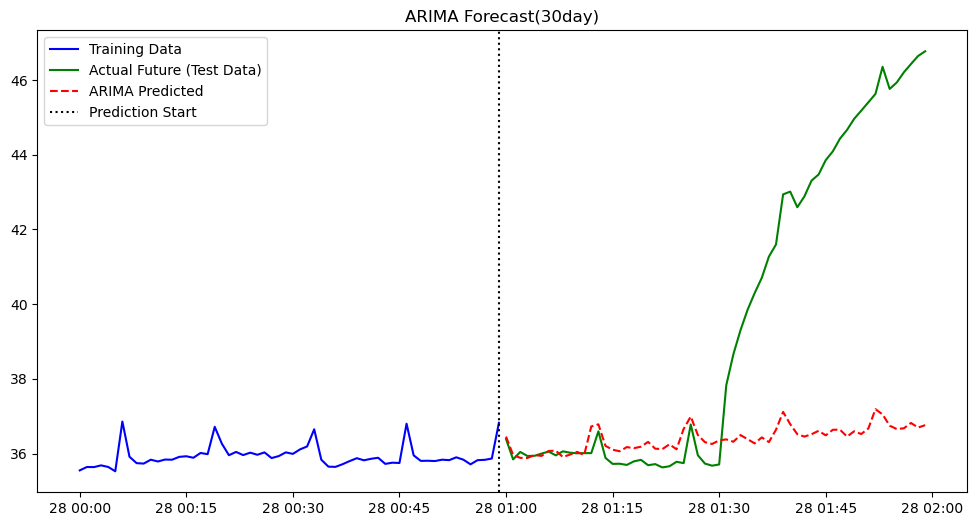

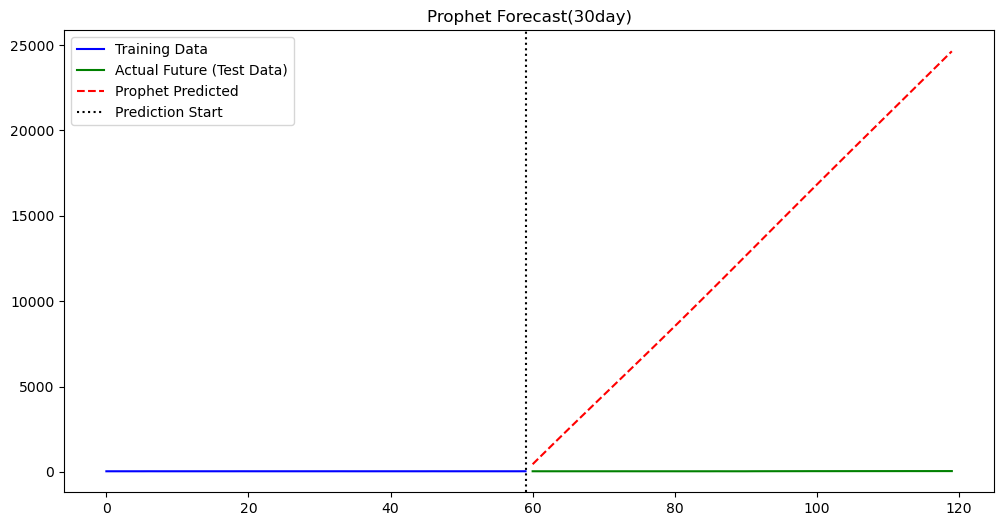

In [124]:
# 시각화 (ARIMA)
plt.figure(figsize=(12, 6))

# 실제값
plt.plot(train["ds"], train["y"], label="Training Data", color="blue")
plt.plot(test["ds"], test["y"], label="Actual Future (Test Data)", color="green")
# ARIMA 예측값
plt.plot(forecast_arima_df["ds"], forecast_arima_df["yhat"], label="ARIMA Predicted", color="red", linestyle="dashed")

plt.axvline(train["ds"].iloc[-1], color="black", linestyle="dotted", label="Prediction Start")
plt.legend()
plt.title("ARIMA Forecast(30day)")
plt.show()


# 시각화 (Prophet)
plt.figure(figsize=(12, 6))
# 실제값
plt.plot(train.index, train["y"], label="Training Data", color="blue")
plt.plot(test.index, test["y"], label="Actual Future (Test Data)", color="green")
# Prophet 예측값
plt.plot(forecast_prophet.index+train.index[0], forecast_prophet["yhat"], label="Prophet Predicted", color="red", linestyle="dashed")

plt.axvline(train.index[-1], color="black", linestyle="dotted", label="Prediction Start")
plt.legend()
plt.title("Prophet Forecast(30day)")
plt.show()


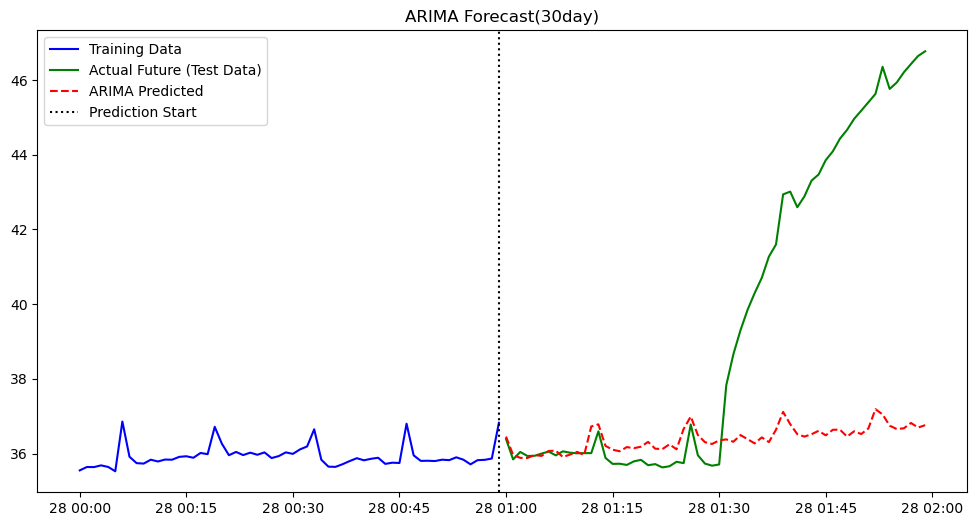

In [97]:
# 시각화 (ARIMA)
plt.figure(figsize=(12, 6))

# 실제값
plt.plot(train["ds"], train["y"], label="Training Data", color="blue")
plt.plot(test["ds"], test["y"], label="Actual Future (Test Data)", color="green")
# ARIMA 예측값
plt.plot(forecast_arima_df["ds"], forecast_arima_df["yhat"], label="ARIMA Predicted", color="red", linestyle="dashed")

plt.axvline(train["ds"].iloc[-1], color="black", linestyle="dotted", label="Prediction Start")
plt.legend()
plt.title("ARIMA Forecast(30day)")
plt.show()

In [112]:
train.head(5)

,ds,y
0,2024-09-28 00:00:00,35.548
1,2024-09-28 00:01:00,35.638
2,2024-09-28 00:02:00,35.636
3,2024-09-28 00:03:00,35.682
4,2024-09-28 00:04:00,35.640


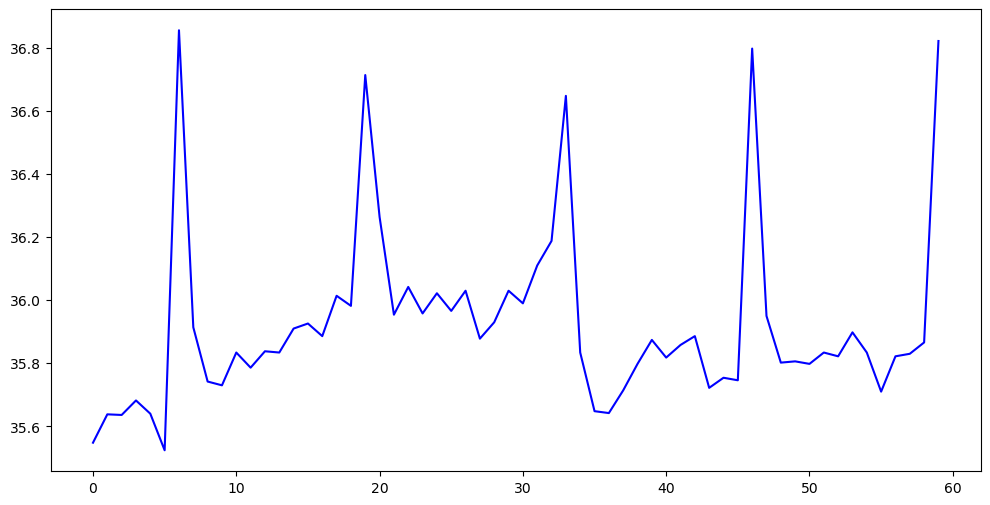

In [113]:
# 시각화 (ARIMA)
plt.figure(figsize=(12, 6))

# 실제값
plt.plot(train.index, train["y"], label="Training Data", color="blue")
# plt.plot(test["ds"], test["y"], label="Actual Future (Test Data)", color="green")
# # ARIMA 예측값
# plt.plot(forecast_arima_df["ds"], forecast_arima_df["yhat"], label="ARIMA Predicted", color="red", linestyle="dashed")

# plt.axvline(train["ds"].iloc[-1], color="black", linestyle="dotted", label="Prediction Start")
# plt.legend()
# plt.title("ARIMA Forecast(30day)")
plt.show()